In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc


In [2]:
def calculate_eddy(width=500e3, num_depth_layers=21, eta0=1, L=1e5, H=1000,
                   a=1, b=1, rho0=1025, f0=None,
                   alpha_1=0.01, alpha_2=0.01,
                   T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None,
                   q11=1.0, q12=0.0, q22=1.0):
    """
    Compute 3D geostrophic U,V and fields for an eddy with prescribed
    quadratic-form shape coefficients q11,q12,q22 (constant in z).
    """
    if f0 is None:
        f0 = 2 * 7.29e-5 * np.sin(np.radians(-34))
    g = 9.81

    x = np.linspace(-width/2, width/2, 51)
    y = np.linspace(-width/2, width/2, 51)
    z = np.linspace(-H, 0, num_depth_layers)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    taper = np.exp(Z / taper_depth) if taper_depth is not None else 1.0

    # center shift with depth
    Xc = alpha_1 * Z
    Yc = alpha_2 * Z

    # elliptical radius-squared
    dX = X - Xc
    dY = Y - Yc
    r2Q = q11 * dX**2 + 2*q12 * dX * dY + q22 * dY**2

    phi = np.exp(-r2Q / L**2) * taper

    T = -2 * phi
    S = 1.5 * phi
    P = -rho0 * g * Z

    alpha = 2e-4
    beta  = 8e-4
    sigma = rho0 * (1 - alpha*(T - T0) + beta*(S - 35))
    sigma -= sigma.mean()

    dx, dy = x[1]-x[0], y[1]-y[0]
    dsdx = np.gradient(sigma, dx, axis=0)
    dsdy = np.gradient(sigma, dy, axis=1)

    U =  g/f0 * dsdy * taper
    V = -g/f0 * dsdx * taper

    # flip so z=0 is first index
    U, V, sigma, T, S, P = [np.flip(arr, axis=2) for arr in (U,V,sigma,T,S,P)]
    z = z[::-1]

    # transpose horizontal slices
    for k in range(U.shape[2]):
        U[:,:,k] = U[:,:,k].T
        V[:,:,k] = V[:,:,k].T

    return U, V, sigma, T, S, P, x/1000, y/1000, z/1000


In [3]:
def dopioe(x1, y1, u1, v1, x2, y2, u2, v2):
    def find_root(x, y, degree=3):
        """Fit a degree-3 polynomial to (x, y) and return the real root closest to x's midpoint."""
        coeffs = np.polyfit(x, y, degree)
        roots = np.roots(np.poly1d(coeffs))
        real_roots = roots[np.isreal(roots)].real
        mid_x = x[len(x) // 2]
        return real_roots[np.argmin(np.abs(real_roots - mid_x))]
    
    def tangent_at_root(x, y, root_x, degree=3):
        coeffs = np.polyfit(x, y, degree)
        slope = np.polyval(np.polyder(coeffs), root_x)
        intercept = np.polyval(coeffs, root_x) - slope * root_x
        y_fit = np.polyval(coeffs, x)
        r2 = 1 - np.sum((y - y_fit)**2) / np.sum((y - np.mean(y))**2) if np.sum((y - np.mean(y))**2) != 0 else 1.0
        return slope, intercept, r2

    if np.any(np.isnan(u1)) or np.any(np.isnan(u2)):
        return np.nan, np.nan, np.nan, np.nan

    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common_points = points1 & points2
    
    if len(common_points) != 1:
        print(f"Warning: Expected 1 common point, found {len(common_points)}.")
        return np.nan, np.nan, np.nan, np.nan
    
    center_x, center_y = next(iter(common_points))

    xx = x1 - center_x
    yy = y2 - center_y

    # Compute roots and tangents
    root_x = find_root(xx, v1)
    A1, A0, r2A = tangent_at_root(xx, u1, root_x)
    B1, B0, r2B = tangent_at_root(xx, v1, root_x)
    root_y = find_root(yy, u2)
    C1, C0, r2C = tangent_at_root(yy, u2, root_y)
    D1, D0, r2D = tangent_at_root(yy, v2, root_y)
    
    alpha = A0 if r2A > r2C else C0
    beta  = B0 if r2B > r2D else D0
    gamma = A1 if r2A > r2D else -D1
    
    q11 = B1 / 2
    q22 = -C1 / 2
    q12 = -gamma / 2
    denom = C1 * B1 + gamma**2
    if denom == 0:
        raise ZeroDivisionError("Denominator is zero.")
        
    x0 = - (alpha * gamma + beta * C1) / denom
    y0 = (beta * gamma - alpha * B1) / denom
    w = 2 * (q11 + q22)

    Q = np.array([[q11, q12], [q12, q22]])

    return x0 + center_x, y0 + center_y, w, Q
    

In [4]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=400)
X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
dx


np.float64(10.0)

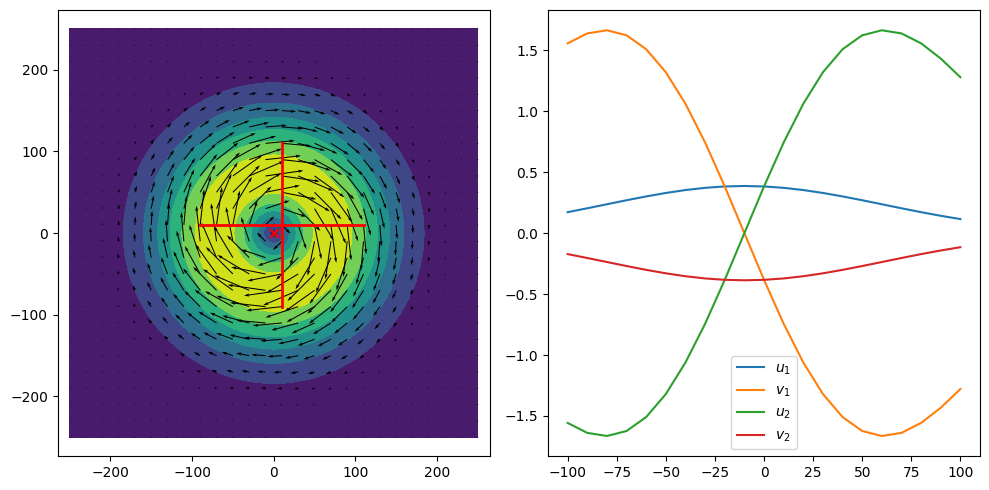

In [5]:
k = 0
u, v = U[:,:,k], V[:,:,k]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].contourf(X, Y, np.hypot(u, v))
spacing = 2
axs[0].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing], u[::spacing, ::spacing], v[::spacing, ::spacing])
axs[0].axis('equal')

ic, jc, rc = X.shape[0]//2 + 1, X.shape[1]//2 + 1, 10

u1 = u.T[ic - rc: ic + rc + 1, jc]
v1 = v.T[ic - rc: ic + rc + 1, jc]
x1 = X.T[ic - rc: ic + rc + 1, jc]
y1 = Y.T[ic - rc: ic + rc + 1, jc]
u2 = u.T[ic, jc - rc: jc + rc + 1]
v2 = v.T[ic, jc - rc: jc + rc + 1]
x2 = X.T[ic, jc - rc: jc + rc + 1]
y2 = Y.T[ic, jc - rc: jc + rc + 1]

x0, y0, w, Q = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)
q11, q12, q22 = Q[0,0], Q[1,0], Q[1,1]

# x0, y0 = 0, 0
# q11=1.0
# q12=0.0
# q22=1.0


axs[0].scatter(x0, y0, marker='x', color='r')

points1 = set(zip(x1, y1))
points2 = set(zip(x2, y2))
common_points = points1 & points2
center_x, center_y = next(iter(common_points))
xx = x1 - center_x
yy = y2 - center_y

axs[0].plot(x1, y1, 'r', linewidth=2)
axs[0].plot(x2, y2, 'r', linewidth=2)

axs[1].plot(xx, u1, label=r'$u_1$')
axs[1].plot(xx, v1, label=r'$v_1$')
axs[1].plot(yy, u2, label=r'$u_2$')
axs[1].plot(yy, v2, label=r'$v_2$')
axs[1].legend()

plt.tight_layout()
plt.show()


## Eddy Velocity Field Retrieval

We define an **elliptical Gaussian eddy** using a streamfunction

$$
\psi(x, y) = \exp\left(-\frac{1}{R^2} \phi(x, y)\right)
$$

where the scalar field $\phi$ is quadratic in $x$ and $y$

$$
\phi(x, y) = q_{11}(x - x_0)^2 + 2q_{12}(x - x_0)(y - y_0) + q_{22}(y - y_0)^2.
$$

This gives an elliptical shape controlled by the symmetric matrix $Q$

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{12} & q_{22}
\end{bmatrix}.
$$

The geostrophic velocity field is derived from the streamfunction via

$$
u = -\frac{\partial \psi}{\partial y}, \quad v = \frac{\partial \psi}{\partial x}.
$$

We compute the gradients using the chain rule

$$
\frac{\partial \psi}{\partial x} = -\frac{1}{R^2} \frac{\partial \phi}{\partial x} \exp\left(-\frac{1}{R^2} \phi\right), \quad
\frac{\partial \psi}{\partial y} = -\frac{1}{R^2} \frac{\partial \phi}{\partial y} \exp\left(-\frac{1}{R^2} \phi\right)
$$

with

$$
\frac{\partial \phi}{\partial x} = 2q_{11}(x - x_0) + 2q_{12}(y - y_0),
$$
$$
\frac{\partial \phi}{\partial y} = 2q_{22}(y - y_0) + 2q_{12}(x - x_0).
$$
Lets look at the normal velocity along a horizontal transect $y=0$
$$ 
V_N = \frac{2q_{12}y_0-2q_{11}(x-x_0)}{R^2}\exp\left(-\frac{q_{11}(x-x_0)^2-2q_{12}(x-x_0)y_0+q_{22}y_0^2}{R^2}\right)
$$
$$
V_N =\frac{1}{R^2}(Ax+B)\exp\left( -\frac{1}{R^2}(Cx^2+Dx+E) \right)
$$
where
$$ 
A=-2q_{11}, \quad B=2q_{12}y_0+2q_{11}x_0, \quad C=q_{11}, \quad D=-2(x_0q_{11}+q_{12}y_0), \quad E=q_{11}x_0^2+2q_{12}x_0y_0+q_{22}y_0^2
$$
we know the above values, hence we can solve to find optimal $R$.
\
\
Can do the same for the tangential component
$$ 
V_T = \frac{2q_{12}(x-x_0)-2q_{22}y_0}{R^2}\exp\left(-\frac{q_{11}(x-x_0)^2-2q_{12}(x-x_0)y_0+q_{22}y_0^2}{R^2}\right)
$$
$$
V_T =\frac{1}{R^2}(Fx+G)\exp\left( -\frac{1}{R^2}(Cx^2+Dx+E) \right)
$$
where
$$ 
F=2q_{12}, \quad G=-2q_{12}x_0-2q_{22}y_0, \quad C=q_{11}, \quad D=-2(x_0q_{11}+q_{12}y_0), \quad E=q_{11}x_0^2+2q_{12}x_0y_0+q_{22}y_0^2.
$$

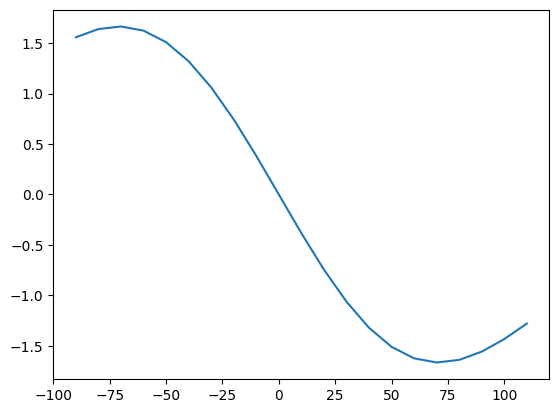

In [6]:
plt.plot(x1, v1)


In [7]:
from scipy.optimize import minimize_scalar

def optimise_R_v1(x, y, x0, y0, q11, q12, q22):
    q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)

    scale = 1
    q11, q12, q22 = scale*q11, scale*q12, scale*q22

    A = -2 * q11
    B = 2 * q12 * y0 + 2 * q11 * x0
    C = q11
    D = -2 * (x0 * q11 + q12 * y0)
    E = q11 * x0**2 + 2 * q12 * x0 * y0 + q22 * y0**2
    print(A, B, C, D, E)

    def residual(R):
        if R <= 0:
            return np.inf
        y_model = (1 / R**2) * (A * x + B) * np.exp((-1 / R**2)* ( C * x**2 + D * x + E))
        return np.sum((y - y_model)**2)

    res = minimize_scalar(residual, bounds=(1e-6, 1000), method='bounded')
    R_opt = res.x
    y_fit = (1 / R_opt**2) * (A * x + B) * np.exp((-1 / R_opt**2) * (C * x**2 + D * x + E))
    return R_opt, y_fit

R_opt_v1, y_fit_v1 = optimise_R_v1(x1, v1, x0, y0, q11, q12, q22)
R_opt_v1


-0.03475112617041079 0.01720161028803321 0.017375563085205395 -0.01720161028803321 0.008460194069569554


np.float64(7.781005218469195)

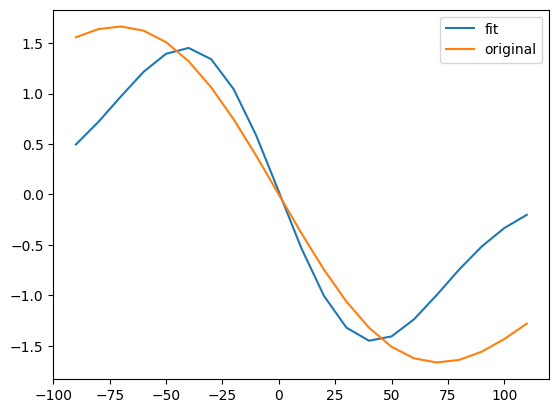

In [8]:
scale = 100
plt.plot(x1, y_fit_v1*scale, label='fit')
plt.plot(x1, v1, label='original')
plt.legend()


In [9]:
from scipy.optimize import minimize_scalar

def optimise_R_u1(x, y, x0, y0, q11, q12, q22):
    q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)
    
    A = 2 * q12
    B = - 2 * q12 * x0 - 2 * q22 * y0
    C = q11
    D = -2 * (x0 * q11 + q12 * y0)
    E = q11 * x0**2 + 2 * q12 * x0 * y0 + q22 * y0**2
    print(A, B, C, D, E)

    def residual(R):
        if R <= 0:
            return np.inf
        y_model = (1 / R**2) * (A * x + B) * np.exp((-1 / R**2)* ( C * x**2 + D * x + E))
        return np.sum((y - y_model)**2)

    res = minimize_scalar(residual, bounds=(1e-6, 1000), method='bounded')
    R_opt = res.x
    y_fit = (1 / R_opt**2) * (A * x + B) * np.exp((-1 / R_opt**2) * (C * x**2 + D * x + E))
    return R_opt, y_fit

R_opt_u1, y_fit_u1 = optimise_R_u1(x1, u1, x0, y0, q11, q12, q22)
R_opt_u1


0.0002238867037826356 -0.01720161028803321 0.017375563085205395 -0.01720161028803321 0.008460194069569554


np.float64(999.9999754271272)

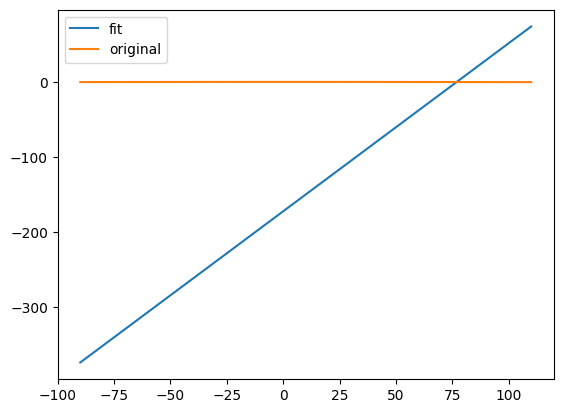

In [10]:
scale = 1e10
plt.plot(x1, y_fit_u1*scale, label='fit')
plt.plot(x1, u1, label='original')
plt.legend()


#### Reconstruct

7.781005218469195


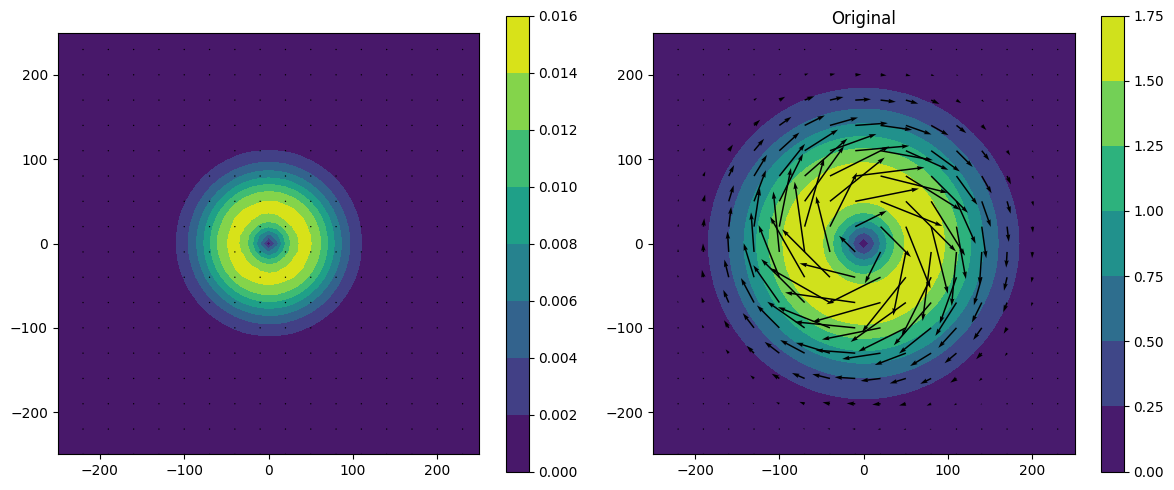

In [20]:
q11, q12, q22 = np.abs(q11), np.abs(q12), np.abs(q22)

width=500
x_phi = np.linspace(-width/2, width/2, 51)
y_phi = np.linspace(-width/2, width/2, 51)
X_phi, Y_phi = np.meshgrid(x_phi, y_phi)

dx_phi, dy_phi = X_phi - x0, Y_phi - y0

phi   = q11*dx_phi**2 + 2*q12*dx_phi*dy_phi + q22*dy_phi**2
phi_x = 2*q11*dx_phi  + 2*q12*dy_phi
phi_y = 2*q22*dy_phi  + 2*q12*dx_phi

u_phi = -phi_y
v_phi =  phi_x

R = R_opt_v1
# R = R_opt_u1
# R = 13
print(R)

# 5) build Gaussian streamfunction with that R
exp_term = np.exp(-phi / R**2)
psi_x = -phi_x / R**2 * exp_term
psi_y = -phi_y / R**2 * exp_term

u_psi = -psi_y 
v_psi =  psi_x 



## Findign the scale factor

# # VORT method
# dv_dx = np.gradient(v_psi, axis=1) / np.gradient(X_phi, axis=1)
# du_dy = np.gradient(u_psi, axis=0) / np.gradient(Y_phi, axis=0)
# vort_gauss = np.abs(dv_dx - du_dy)

# vort_core = w
# scale = np.abs(vort_core) / np.nanmax(np.abs(vort_gauss))
# print(scale)
# u_psi *= scale
# v_psi *= scale

## TRANSECT MATCHING METHOD
u1_psi = u_psi.T[ic - rc: ic + rc + 1, jc]
v1_psi = v_psi.T[ic - rc: ic + rc + 1, jc]
# x1_psi = X.T[ic - rc: ic + rc + 1, jc]
# y1_psi = Y.T[ic - rc: ic + rc + 1, jc]
x1_psi = x1
y1_psi = y1
u2_psi = u_psi.T[ic, jc - rc: jc + rc + 1]
v2_psi = v_psi.T[ic, jc - rc: jc + rc + 1]
# x2_psi = X.T[ic, jc - rc: jc + rc + 1]
# y2_psi = Y.T[ic, jc - rc: jc + rc + 1]
x2_psi = x2
y2_psi = y2








fig, axs = plt.subplots(1, 2, figsize=(12, 5))

spacing = 3
dist = 50
scale = 10
# Plot 1
mag_psi = np.hypot(u_psi, v_psi)
# mask = np.hypot(X_phi, Y_phi) <= dist
# mag_phi = np.where(mask, mag_phi, np.nan)
axs[0].contourf(X_phi, Y_phi, mag_psi)#, vmin=0, vmax=1.75)
spacing = 3
axs[0].quiver(X_phi[::spacing, ::spacing], Y_phi[::spacing, ::spacing],
              u_psi[::spacing, ::spacing], v_psi[::spacing, ::spacing],
              scale=scale)
axs[0].set_aspect('equal')
plt.colorbar(axs[0].collections[0], ax=axs[0])

# Plot 2
mag = np.hypot(u, v)
# mask = np.hypot(X, Y) <= dist
# mag = np.where(mask, mag, np.nan)
axs[1].contourf(X, Y, mag)
spacing = 3
axs[1].quiver(X[::spacing, ::spacing], Y[::spacing, ::spacing],
              u[::spacing, ::spacing], v[::spacing, ::spacing], scale=scale)
axs[1].set_aspect('equal')
plt.colorbar(axs[1].collections[0], ax=axs[1])
axs[1].set_title('Original')

plt.tight_layout()
plt.show()


In [14]:
## TRANSECT MATCHING METHOD
u1_psi = u_psi.T[ic - rc: ic + rc + 1, jc]
v1_psi = v_psi.T[ic - rc: ic + rc + 1, jc]
# x1_psi = X.T[ic - rc: ic + rc + 1, jc]
# y1_psi = Y.T[ic - rc: ic + rc + 1, jc]
x1_psi = x1
y1_psi = y1
u2_psi = u_psi.T[ic, jc - rc: jc + rc + 1]
v2_psi = v_psi.T[ic, jc - rc: jc + rc + 1]
# x2_psi = X.T[ic, jc - rc: jc + rc + 1]
# y2_psi = Y.T[ic, jc - rc: jc + rc + 1]
x2_psi = x2
y2_psi = y2


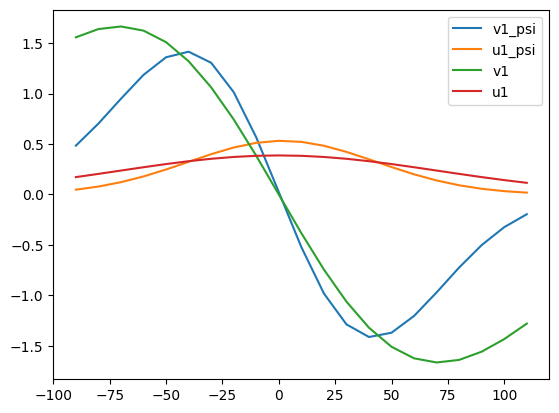

In [22]:
scale = 100

plt.plot(x1_psi, v1_psi*scale, label='v1_psi')
plt.plot(x1_psi, u1_psi*scale, label='u1_psi')

plt.plot(x1, v1, label='v1')
plt.plot(x1, u1, label='u1')
plt.legend()

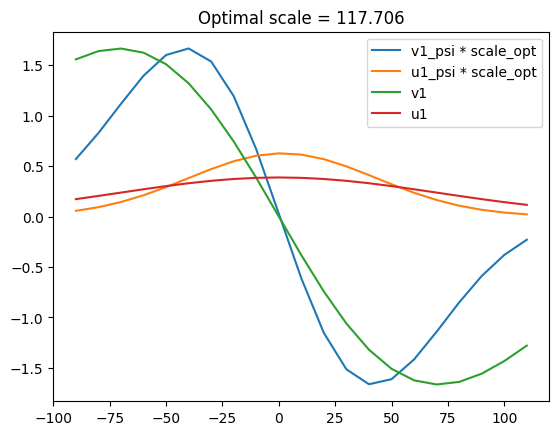

In [23]:
from scipy.optimize import minimize_scalar

def objective(scale):
    return np.sum((u1 - u1_psi * scale)**2 + (v1 - v1_psi * scale)**2)

res = minimize_scalar(objective)
scale_opt = res.x

# Plot with optimal scale
plt.plot(x1_psi, v1_psi * scale_opt, label='v1_psi * scale_opt')
plt.plot(x1_psi, u1_psi * scale_opt, label='u1_psi * scale_opt')
plt.plot(x1, v1, label='v1')
plt.plot(x1, u1, label='u1')
plt.legend()
plt.title(f'Optimal scale = {scale_opt:.3f}')
plt.show()
